In [1]:
import pnet_loader
import util
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import Pnet
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import os

%load_ext autoreload
%autoreload 2

In [2]:
directories = ['../data/' + x for x in os.listdir('../data/') if 'tcga_pan_can_atlas' in x]

In [3]:
def load_single_dataset(directory_path):
    rna_exp = pd.read_csv(directory_path + '/data_mrna_seq_v2_rsem.txt',
                           sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
    rna_exp = rna_exp.loc[:,~rna_exp.columns.duplicated()].astype(float).copy()
    cna = pd.read_csv(directory_path + '/data_cna.txt',
                      sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
    cna.drop('Cytoband', errors='ignore', inplace=True)
    cna = cna.loc[:,~cna.columns.duplicated()].astype(float).copy()
    
    genes = list(set(rna_exp.columns).intersection(cna.columns))
    indices = list(set(rna_exp.index).intersection(cna.index))
    tumor_type = pd.DataFrame(len(indices)*[directory_path.split('/')[-1].split('_')[0]],
                              index = indices, columns=['tumor'])
    return rna_exp[genes], cna[genes], tumor_type

In [4]:
rna, cna, tumor = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for path in directories:
    rna_, cna_, tumor_ = load_single_dataset(path)
    rna = pd.concat([rna_, rna])
    cna = pd.concat([cna_, cna])
    tumor = pd.concat([tumor_, tumor])
    
rna.dropna(axis=1, inplace=True)
cna.dropna(axis=1, inplace=True)
rna = (rna-rna.mean())/rna.std()

### External validation dataset

In [19]:
rna_ext_val = pd.read_csv('../data/mel_dfci_2019/data_RNA_Seq_expression_tpm_all_sample_Zscores.txt',
                          delimiter='\t').set_index('Hugo_Symbol').T.drop('Entrez_Gene_Id').dropna(axis=1)
cna_ext_val = pd.read_csv('../data/mel_dfci_2019/data_CNA.txt',
                          delimiter='\t').set_index('Hugo_Symbol').T.dropna(axis=1)
genes = list(set.intersection(set(rna.columns), set(cna.columns), set(rna_ext_val.columns), set(cna_ext_val.columns)))
rna = rna[genes].copy()
cna = cna[genes].copy()
rna_ext_val = rna_ext_val[genes].copy()
cna_ext_val = cna_ext_val[genes].copy()

In [20]:
genetic_data = {'rna': rna, 'cna': cna}

In [21]:
absolute_TCGA = pd.read_csv('../data/m1000/TCGA_mastercalls.abs_tables_JSedit.fixed.txt',
                            delimiter='\t', index_col='array')
absolute_ploidy = absolute_TCGA[['ploidy']].join(rna, how='inner')['ploidy']
absolute_ploidy.dropna(inplace=True)

In [22]:
gm = GaussianMixture(n_components=2, random_state=0).fit(absolute_ploidy.values.reshape(-1, 1))
y = gm.predict_proba(np.linspace(0,absolute_ploidy.max(),1000).reshape(-1,1))
ma = np.linspace(0,absolute_ploidy.max(),1000)[y[:,1] < 0.5].max()
absolute_ploidy_y = pd.DataFrame(index=absolute_ploidy.index, columns=['dichtomized_ploidy'],
                               data=[int(p > ma) 
                                     for p in absolute_ploidy.values])

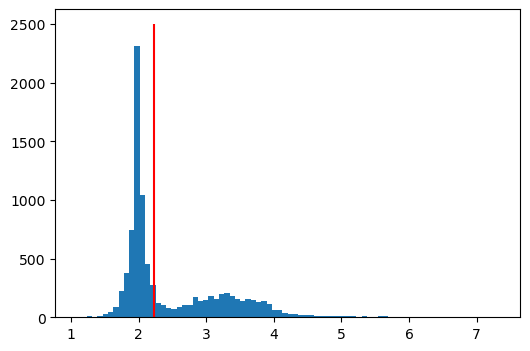

In [23]:
plt.rcParams["figure.figsize"] = (6,4)
plt.hist(absolute_ploidy, bins=80)
plt.vlines([ma], color='r', ymin=0, ymax=2500)
plt.savefig('../figures/ploidy_cutoff_selection.pdf')
plt.show()

In [24]:
absolute_ploidy_y.sum()/absolute_ploidy_y.count()

dichtomized_ploidy    0.388473
dtype: float64

In [25]:
tumor_order = list(tumor.join(absolute_ploidy).groupby('tumor').median().sort_values('ploidy', ascending=False).index)

In [26]:
coloring = (tumor.join(absolute_ploidy).groupby('tumor').median().sort_values('ploidy', ascending=False) > 2.5)

In [27]:
coloring['color'] = coloring['ploidy'].apply(lambda x: 'aquamarine' if x else 'whitesmoke')

/var/folders/j8/df8v0y1j16ng5mlcnmr38r0r0000gp/T/ipykernel_90862/2850431863.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tumor_order = list(df.groupby('tumor').median().sort_values('ploidy', ascending=False).index)


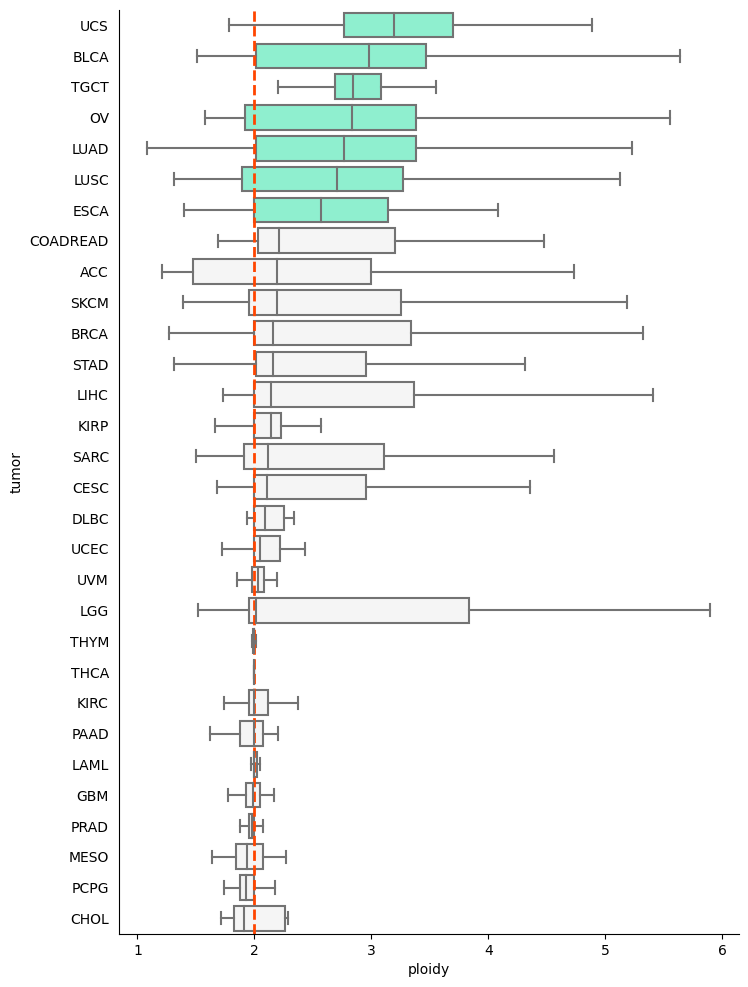

In [28]:
df = tumor.join(absolute_ploidy)
df['tumor'] = [x.upper() for x in list(df['tumor'].values)]
df['coloring'] = coloring['ploidy']
tumor_order = list(df.groupby('tumor').median().sort_values('ploidy', ascending=False).index)
plt.rcParams["figure.figsize"] = (8,12)
sns.boxplot(data=df, x='ploidy', y='tumor', order=tumor_order, color='w', palette=coloring['color'], showfliers=False)
plt.axvline(2, color='orangered', linestyle='--', linewidth=2)
plt.tick_params(axis='y', which='both',  left=False, top=False, labelleft=True)
sns.despine()
plt.savefig('../figures/ploidy_by_tumortype.pdf')

In [29]:
heterogeneity = pd.read_csv('../data/heterogeneity.tsv', delimiter=' ')
heterogeneity

,sample,patient_s,n_clonal,n_subclonal,total_nonsyn,heterogeneity
0,TCGA-02-0003-01A-01D-1490-08,TCGA-02-0003-01A-01D-1490-08,33,13,46,0.282609
1,TCGA-02-0033-01A-01D-1490-08,TCGA-02-0033-01A-01D-1490-08,19,9,28,0.321429
2,TCGA-02-0047-01A-01D-1490-08,TCGA-02-0047-01A-01D-1490-08,28,36,64,0.562500
3,TCGA-02-0055-01A-01D-1490-08,TCGA-02-0055-01A-01D-1490-08,39,9,48,0.187500
4,TCGA-02-2466-01A-01W-0837-08,TCGA-02-2466-01A-01W-0837-08,31,72,103,0.699029
...,...,...,...,...,...,...
9430,TCGA-ZS-A9CF-02A-11D-A382-10,TCGA-ZS-A9CF-02A-11D-A382-10,97,25,122,0.204918
9431,TCGA-ZS-A9CG-01A-11D-A36X-10,TCGA-ZS-A9CG-01A-11D-A36X-10,56,20,76,0.263158
9432,TCGA-ZT-A8OM-01A-11D-A428-09,TCGA-ZT-A8OM-01A-11D-A428-09,3,22,25,0.880000
9433,TCGA-ZU-A8S4-01A-11D-A417-09,TCGA-ZU-A8S4-01A-11D-A417-09,24,23,47,0.489362


## Select genes

In [30]:
pca = PCA(n_components=50)
pca.fit(rna.values)

PCA(n_components=50)

In [31]:
pca_loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), index=rna.columns)

In [32]:
genes_pca = abs(pca_loadings).sum(axis=1).nlargest(1000).index

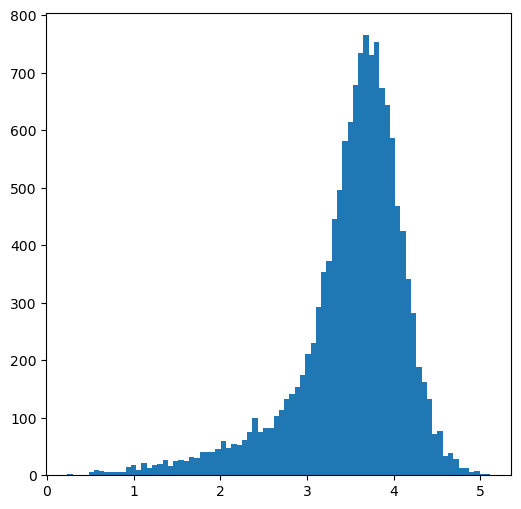

In [33]:
plt.rcParams["figure.figsize"] = (6,6)
plt.hist(abs(pca_loadings).sum(axis=1), bins=80)
plt.show()

## Run pnet

In [34]:
import Pnet

In [35]:
genetic_data = {'rna': rna[genes_pca]}

In [28]:
train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, absolute_ploidy_y)

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (6365, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (2727, 1000)


In [29]:
import ReactomeNetwork

In [30]:
reactome_network = ReactomeNetwork.ReactomeNetwork(train_dataset.get_genes())

Found 1000 overlapping genes


In [31]:
model = Pnet.PNET_NN(reactome_network=reactome_network, nbr_gene_inputs=len(genetic_data), dropout=0.2,
                      additional_dims=0, lr=1e-3, weight_decay=1)

In [32]:
train_loader, val_loader = pnet_loader.to_dataloader(train_dataset, test_dataset, 64)

In [33]:
import pytorch_lightning as pl

In [34]:
# trainer = pl.Trainer(precision=32, accelerator='cuda', max_epochs=100, log_every_n_steps=50, 
#                      enable_checkpointing=True)

# trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader,)

model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         absolute_ploidy_y,
                                                                         verbose=True,
                                                                         early_stopping=True)

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (6365, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (2727, 1000)
Found 1000 overlapping genes
Epoch 1 of 300
Train scores: (0.6739432260733558, 0.6120974076983503)
Test scores: (0.6616936205593622, 0.6087275394206088)
Epoch 2 of 300
Train scores: (0.6397367733628002, 0.48483896307934016)
Test scores: (0.6232348149365717, 0.3876054272093876)
Epoch 3 of 300
Train scores: (0.6227718038626384, 0.3190887666928515)
Test scores: (0.6096231539607004, 0.2687935460212688)
Epoch 4 of 300
Train scores: (0.6119116966685065, 0.2656716417910448)
Test scores: (0.6033645220016183, 0.22368903557022368)
Epoch 5 of 300
Train scores: (0.6062922118876922, 0.2589159465828751)
Test scores: (0.5981063192302507, 0.23945727906123945)
Epoch 6 of 300
Train scores: (0.6037252475591691, 0.25765907305577374)
Test scores: (0

In [35]:
x_train = train_dataset.x
additional_train = train_dataset.additional
y_train = train_dataset.y
x_test = test_dataset.x
additional_test = test_dataset.additional
y_test = test_dataset.y

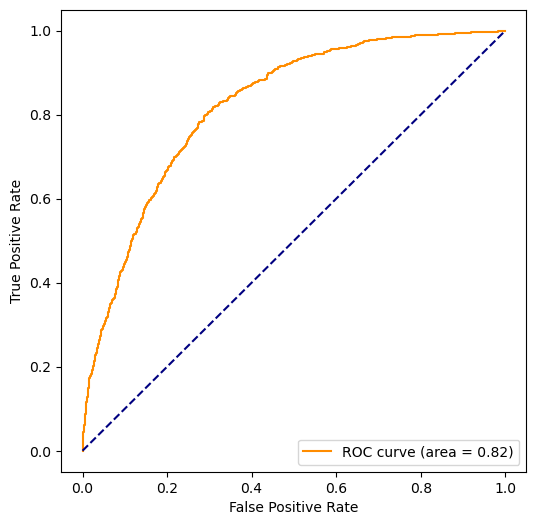

In [42]:
pred = model(x_test, additional_test)
y_pred_proba = pred.detach().numpy().squeeze()
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
test_auc = metrics.roc_auc_score(y_test, pred.detach().numpy().squeeze())
#create ROC curve
plt.plot(fpr,tpr, color="darkorange", label="ROC curve (area = %0.2f)" % test_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.legend(loc="lower right")
plt.savefig('PNET_ploidy_ROC_curve_rna_only.pdf')
plt.show()

### External Validation

In [37]:
ext_val_ploidy = pd.read_csv('../data/mel_dfci_2019/data_clinical_sample.txt',
                             delimiter='\t').set_index('Sample Identifier').iloc[4:]
ext_val_target = (ext_val_ploidy['Ploidy'].astype('float') > ma).astype('int')

In [39]:
inds = pnet_loader.get_indicies(genetic_data = {'rna': rna_ext_val[genes_pca]},
                                target=ext_val_target)
ext_val_dataset = pnet_loader.PnetDataset(genetic_data = {'rna': rna_ext_val[genes_pca]},
                                          target=ext_val_target, indicies=inds)

Found 121 overlapping indicies
Found 1000 overlapping genes
generated input DataFrame of size (121, 1000)


In [40]:
x_val = ext_val_dataset.x
additional_val = ext_val_dataset.additional
y_val = ext_val_dataset.y

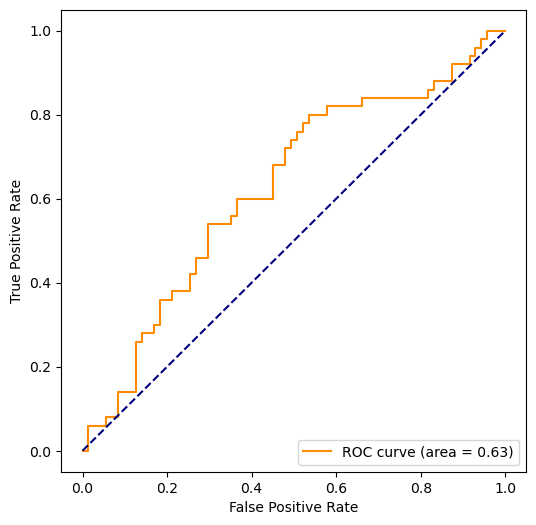

In [43]:
pred = model(x_val, additional_val)
y_pred_proba = pred.detach().numpy().squeeze()
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
test_auc = metrics.roc_auc_score(y_val, pred.detach().numpy().squeeze())
#create ROC curve
plt.plot(fpr,tpr, color="darkorange", label="ROC curve (area = %0.2f)" % test_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.legend(loc="lower right")
plt.savefig('PNET_ploidy_ROC_curve_ext_val_rna_only.pdf')
plt.show()

## Leave one (cancer type) out training

In [13]:
cancer_types = tumor['tumor'].unique()

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (9056, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (36, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6536888844554078
Test Loss: 0.6026590135362413
Epoch 2 of 10
Train Loss: 0.6239007239628175
Test Loss: 0.5920062065124512
Epoch 3 of 10
Train Loss: 0.6076923465560266
Test Loss: 0.5898593266805013
Epoch 4 of 10
Train Loss: 0.5950480716388554
Test Loss: 0.5727593104044596
Epoch 5 of 10
Train Loss: 0.5846865017085531
Test Loss: 0.5837363137139214
exceeded delta
Epoch 6 of 10
Train Loss: 0.5787634167148873
Test Loss: 0.6053890122307671
exceeded delta
Epoch 7 of 10
Train Loss: 0.5712692013056455
Test Loss: 0.5613793796963162
Epoch 8 of 10
Train Loss: 0.5644578190237389
Test Loss: 0.5871186786227756
exceeded delta
Epoch 9 of 10
Train Loss: 0.564246730332661
Test Loss: 0.548929903

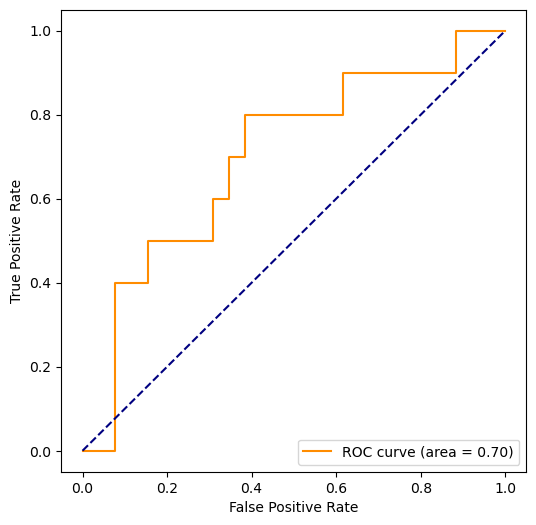

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8578, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (514, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.670929944009374
Test Loss: 0.6003913744878212
Epoch 2 of 10
Train Loss: 0.6556761371808665
Test Loss: 0.5969086034288666
Epoch 3 of 10
Train Loss: 0.6333652657627586
Test Loss: 0.5955993577200152
Epoch 4 of 10
Train Loss: 0.6143312806098103
Test Loss: 0.5652355813794563
Epoch 5 of 10
Train Loss: 0.5986774023887188
Test Loss: 0.5740224503357587
exceeded delta
Epoch 6 of 10
Train Loss: 0.5866260737159864
Test Loss: 0.5508160836965658
Epoch 7 of 10
Train Loss: 0.5795301736360053
Test Loss: 0.524619350173594
Epoch 8 of 10
Train Loss: 0.5774409818771586
Test Loss: 0.49102691963952805
Epoch 9 of 10
Train Loss: 0.5722460216451953
Test Loss: 0.5058307545658215
exceeded delta
Epoch 

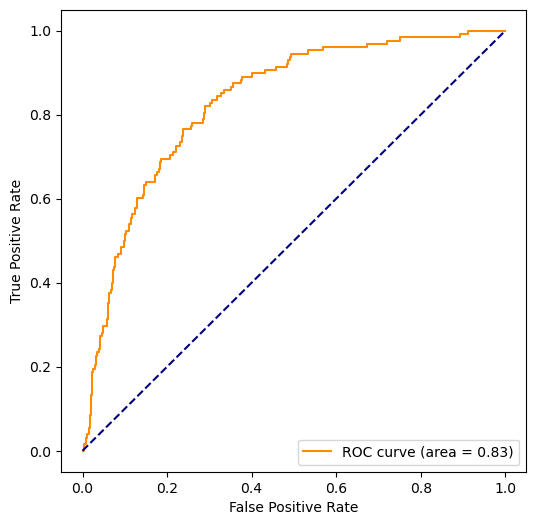

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (9036, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (56, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6910155010518906
Test Loss: 0.7566014698573521
Epoch 2 of 10
Train Loss: 0.6561391884481659
Test Loss: 0.7875795364379883
exceeded delta
Epoch 3 of 10
Train Loss: 0.6386211141119388
Test Loss: 0.7299962724958148
Epoch 4 of 10
Train Loss: 0.6278424974351184
Test Loss: 0.6969376972743443
Epoch 5 of 10
Train Loss: 0.623965238669954
Test Loss: 0.7401219776698521
exceeded delta
Epoch 6 of 10
Train Loss: 0.6198391654735226
Test Loss: 0.678304944719587
Epoch 7 of 10
Train Loss: 0.6191328180844196
Test Loss: 0.6825170516967773
Epoch 8 of 10
Train Loss: 0.6189659991692842
Test Loss: 0.686227525983538
exceeded delta
Epoch 9 of 10
Train Loss: 0.6218203389048312
Test Loss: 0.71226583208

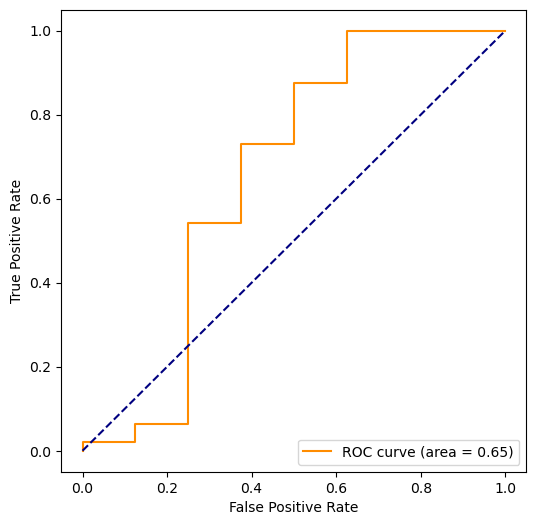

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8611, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (481, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6662301626261927
Test Loss: 0.579275285875475
Epoch 2 of 10
Train Loss: 0.6403755203050377
Test Loss: 0.5311132696710852
Epoch 3 of 10
Train Loss: 0.6218276229307302
Test Loss: 0.5206575215234578
Epoch 4 of 10
Train Loss: 0.6096108952350503
Test Loss: 0.5038972604795207
Epoch 5 of 10
Train Loss: 0.60221089066397
Test Loss: 0.5011484380075689
Epoch 6 of 10
Train Loss: 0.5945365439722754
Test Loss: 0.4905091085453787
Epoch 7 of 10
Train Loss: 0.5902644746492666
Test Loss: 0.4844890800682274
Epoch 8 of 10
Train Loss: 0.5885506145852518
Test Loss: 0.48574357221131514
Epoch 9 of 10
Train Loss: 0.5846024507596344
Test Loss: 0.4910619858644608
exceeded delta
Epoch 10 of 10
Train L

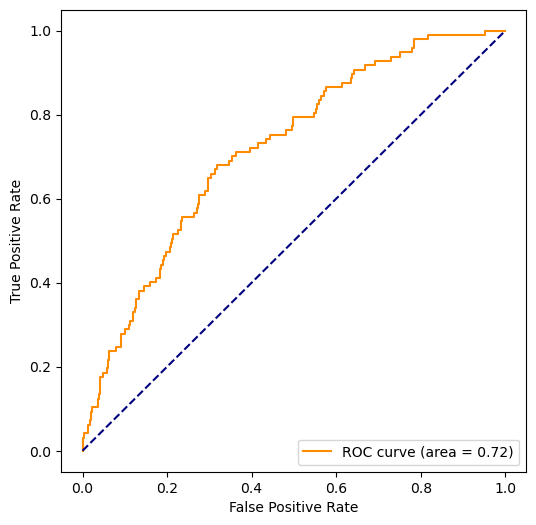

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8695, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (397, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6794913833205765
Test Loss: 0.7037867202566613
Epoch 2 of 10
Train Loss: 0.6428525068075784
Test Loss: 0.6961718446361628
Epoch 3 of 10
Train Loss: 0.6250721089657592
Test Loss: 0.7010215499839495
Epoch 4 of 10
Train Loss: 0.615350121996607
Test Loss: 0.7080553424748726
exceeded delta
Epoch 5 of 10
Train Loss: 0.6042228474981693
Test Loss: 0.6908676281984267
Epoch 6 of 10
Train Loss: 0.6000985615550958
Test Loss: 0.6663423845689903
Epoch 7 of 10
Train Loss: 0.5975296672011601
Test Loss: 0.6713377858889794
Epoch 8 of 10
Train Loss: 0.5928308040537733
Test Loss: 0.6747987684735123
exceeded delta
Epoch 9 of 10
Train Loss: 0.5923632432565804
Test Loss: 0.6854862962621886
exceed

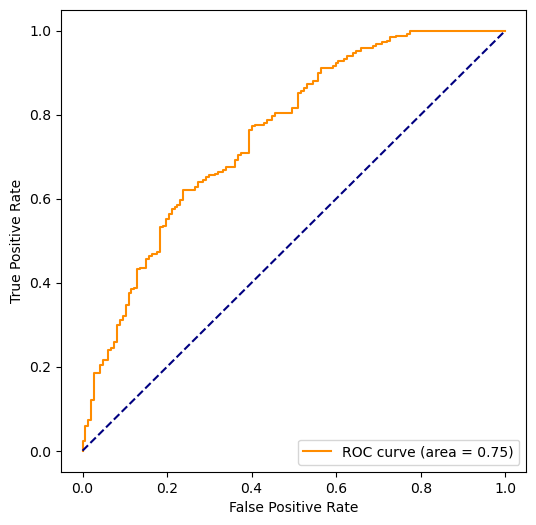

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8735, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (357, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6569537463567566
Test Loss: 0.6958829895788882
Epoch 2 of 10
Train Loss: 0.6256870097273339
Test Loss: 0.6872322712959695
Epoch 3 of 10
Train Loss: 0.605379331050495
Test Loss: 0.681369685325302
Epoch 4 of 10
Train Loss: 0.5960227348358207
Test Loss: 0.6806147492566362
Epoch 5 of 10
Train Loss: 0.5923054689124576
Test Loss: 0.680184527271602
Epoch 6 of 10
Train Loss: 0.5917718608923892
Test Loss: 0.679493612935897
Epoch 7 of 10
Train Loss: 0.5924253567464706
Test Loss: 0.6786728920388956
Epoch 8 of 10
Train Loss: 0.5952796302799778
Test Loss: 0.6777690598944656
Epoch 9 of 10
Train Loss: 0.5924024200876167
Test Loss: 0.6784480813504601
Epoch 10 of 10
Train Loss: 0.5963101667

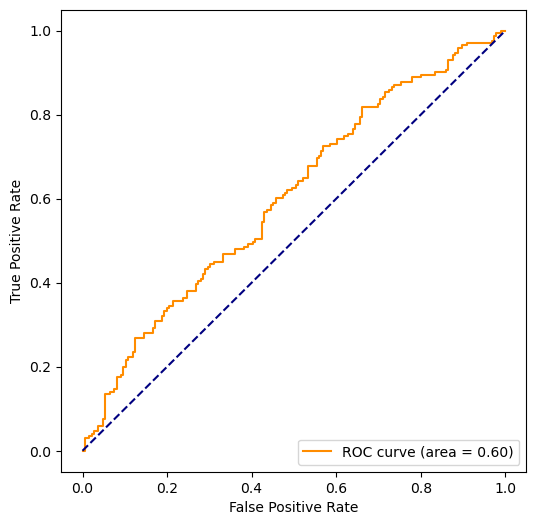

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8802, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (290, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6518014813791322
Test Loss: 0.6651568840289938
Epoch 2 of 10
Train Loss: 0.6180145653289331
Test Loss: 0.6565387133894296
Epoch 3 of 10
Train Loss: 0.6014356086590539
Test Loss: 0.6551535902352169
Epoch 4 of 10
Train Loss: 0.5958155242184893
Test Loss: 0.6562894097689924
Epoch 5 of 10
Train Loss: 0.5929014959597528
Test Loss: 0.6528893437878839
Epoch 6 of 10
Train Loss: 0.591754389578471
Test Loss: 0.662766956460887
exceeded delta
Epoch 7 of 10
Train Loss: 0.5939403361446395
Test Loss: 0.6508320578213396
Epoch 8 of 10
Train Loss: 0.5951709792820385
Test Loss: 0.6535366781826677
Epoch 9 of 10
Train Loss: 0.595457107797045
Test Loss: 0.6479124792690935
Epoch 10 of 10
Train Lo

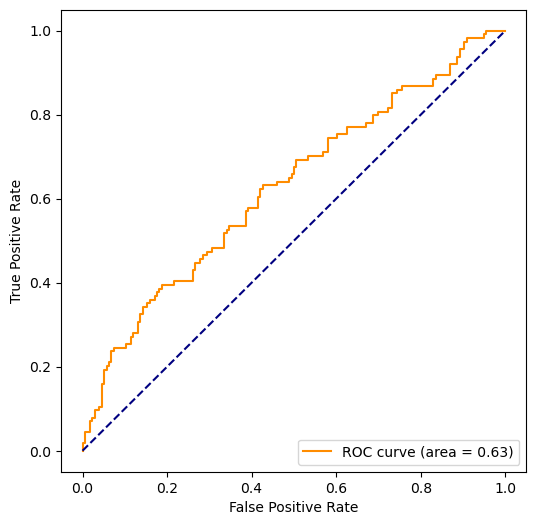

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8613, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (479, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6456616314310348
Test Loss: 0.705164684383257
Epoch 2 of 10
Train Loss: 0.6206581853593972
Test Loss: 0.6924095631641236
Epoch 3 of 10
Train Loss: 0.6067780269143143
Test Loss: 0.6814049141392081
Epoch 4 of 10
Train Loss: 0.6003231078258281
Test Loss: 0.6779008200372684
Epoch 5 of 10
Train Loss: 0.5905530015641384
Test Loss: 0.6729457273861561
Epoch 6 of 10
Train Loss: 0.5862056077128709
Test Loss: 0.6702770758770205
Epoch 7 of 10
Train Loss: 0.5842362468865197
Test Loss: 0.6672369851448839
Epoch 8 of 10
Train Loss: 0.5838140237210977
Test Loss: 0.6617746771252977
Epoch 9 of 10
Train Loss: 0.5772441933548964
Test Loss: 0.6568914903230607
Epoch 10 of 10
Train Loss: 0.5767549

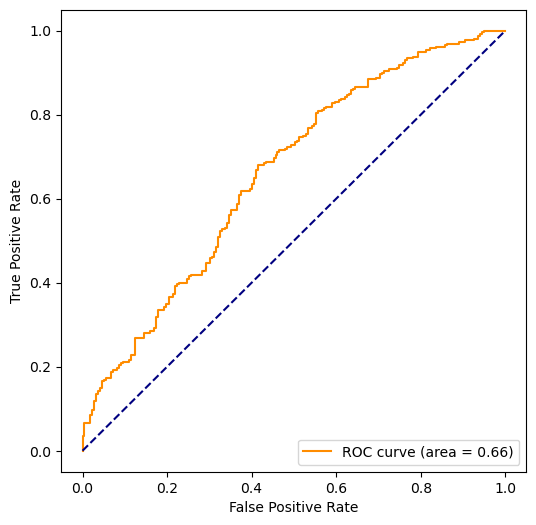

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8989, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (103, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6972744473096513
Test Loss: 0.6546818446187139
Epoch 2 of 10
Train Loss: 0.6669304067187533
Test Loss: 0.5994902675591626
Epoch 3 of 10
Train Loss: 0.6511093115883497
Test Loss: 0.571272877813543
Epoch 4 of 10
Train Loss: 0.6352307944213447
Test Loss: 0.5179135405901566
Epoch 5 of 10
Train Loss: 0.6236274802839946
Test Loss: 0.5291693233749242
exceeded delta
Epoch 6 of 10
Train Loss: 0.6098134915785471
Test Loss: 0.45570851298211845
Epoch 7 of 10
Train Loss: 0.605644519740979
Test Loss: 0.49947521987470606
exceeded delta
Epoch 8 of 10
Train Loss: 0.6020231460196143
Test Loss: 0.5037255518644759
exceeded delta
Epoch 9 of 10
Train Loss: 0.5944254685594051
Test Loss: 0.5224287

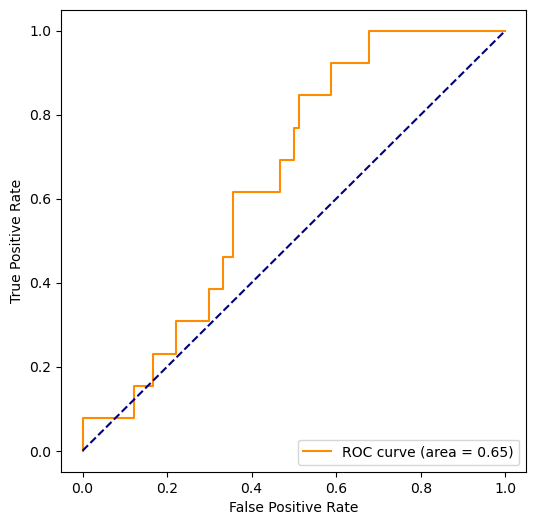

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8052, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (1040, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.645147594124064
Test Loss: 0.6794627373035137
Epoch 2 of 10
Train Loss: 0.6068406957805423
Test Loss: 0.6692161890176627
Epoch 3 of 10
Train Loss: 0.5868898565592721
Test Loss: 0.6529038163331838
Epoch 4 of 10
Train Loss: 0.5731049694946259
Test Loss: 0.6511554993115939
Epoch 5 of 10
Train Loss: 0.5670511676373319
Test Loss: 0.6334581466821524
Epoch 6 of 10
Train Loss: 0.5598831861337736
Test Loss: 0.6276525589135977
Epoch 7 of 10
Train Loss: 0.5531626593338217
Test Loss: 0.6334822948162372
Epoch 8 of 10
Train Loss: 0.5518744298609939
Test Loss: 0.6255934275113619
Epoch 9 of 10
Train Loss: 0.5545399562079576
Test Loss: 0.6225501115505512
Epoch 10 of 10
Train Loss: 0.553916

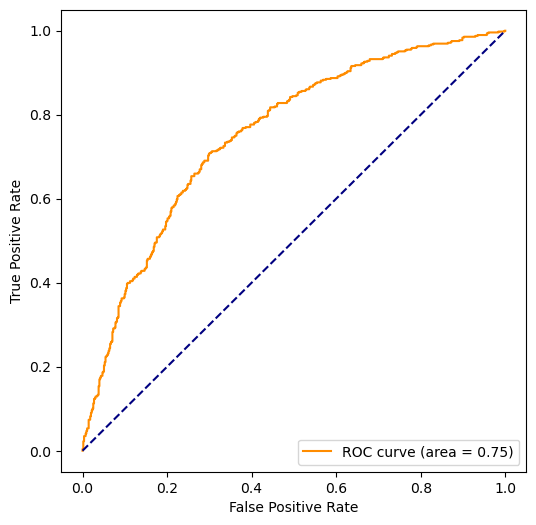

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (9012, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (80, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6748122796449352
Test Loss: 0.5866389751434327
Epoch 2 of 10
Train Loss: 0.6330570228566501
Test Loss: 0.5256689071655274
Epoch 3 of 10
Train Loss: 0.6071884940054699
Test Loss: 0.5354868173599243
exceeded delta
Epoch 4 of 10
Train Loss: 0.5902253225862424
Test Loss: 0.4499558687210083
Epoch 5 of 10
Train Loss: 0.5807956260836923
Test Loss: 0.45959421396255495
exceeded delta
Epoch 6 of 10
Train Loss: 0.5724914411518556
Test Loss: 0.4740756332874298
exceeded delta
Epoch 7 of 10
Train Loss: 0.5674315148652843
Test Loss: 0.4469331681728363
Epoch 8 of 10
Train Loss: 0.5623686809937688
Test Loss: 0.4224910497665405
Epoch 9 of 10
Train Loss: 0.56463740637077
Test Loss: 0.452712392

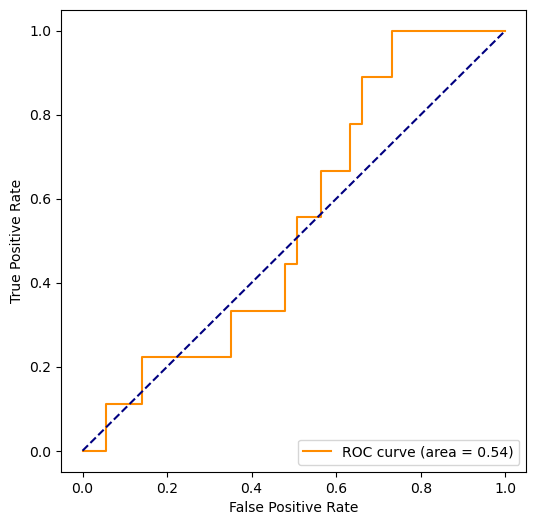

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8983, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (109, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6657266129526943
Test Loss: 0.5299970819315779
Epoch 2 of 10
Train Loss: 0.6485619410685013
Test Loss: 0.5022235135419653
Epoch 3 of 10
Train Loss: 0.6312811394039299
Test Loss: 0.5770902196201709
exceeded delta
Epoch 4 of 10
Train Loss: 0.6191316215203438
Test Loss: 0.5213242977037342
exceeded delta
Epoch 5 of 10
Train Loss: 0.6086895220876603
Test Loss: 0.5140618840488819
exceeded delta
Epoch 6 of 10
Train Loss: 0.6017684024571709
Test Loss: 0.5285656430305691
exceeded delta
Epoch 7 of 10
Train Loss: 0.5989339164539393
Test Loss: 0.46739690238182696
Epoch 8 of 10
Train Loss: 0.5947584343105173
Test Loss: 0.5799381361095184
exceeded delta
Epoch 9 of 10
Train Loss: 0.592401

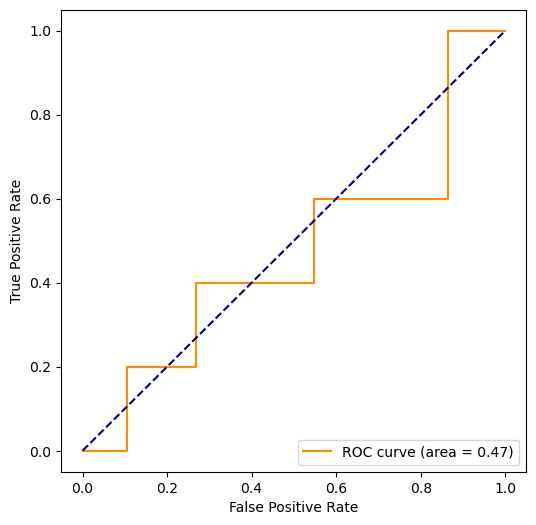

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8850, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (242, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6849486625800698
Test Loss: 0.6831847419423506
Epoch 2 of 10
Train Loss: 0.6398851618793725
Test Loss: 0.6824809775864782
Epoch 3 of 10
Train Loss: 0.6156118341219627
Test Loss: 0.6838910914649649
Epoch 4 of 10
Train Loss: 0.5979713439941406
Test Loss: 0.6710942165910705
Epoch 5 of 10
Train Loss: 0.5853847344177591
Test Loss: 0.6965582823950397
exceeded delta
Epoch 6 of 10
Train Loss: 0.5732259041306663
Test Loss: 0.6845220770717653
exceeded delta
Epoch 7 of 10
Train Loss: 0.5716760468348271
Test Loss: 0.6997163473081983
exceeded delta
Epoch 8 of 10
Train Loss: 0.5664739277403233
Test Loss: 0.6618476111041612
Epoch 9 of 10
Train Loss: 0.5682739963639254
Test Loss: 0.6786526

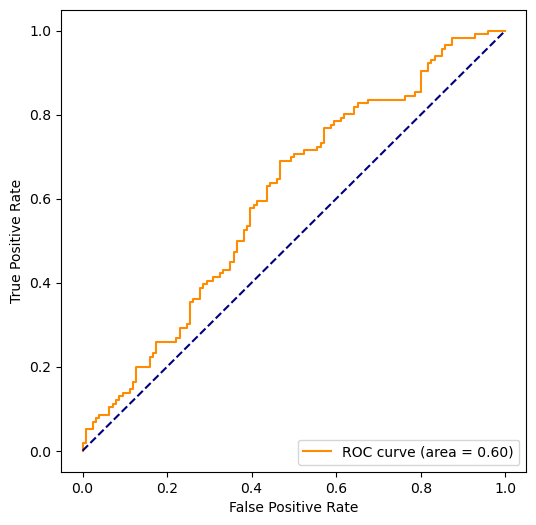

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8931, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (161, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6523041785490792
Test Loss: 0.7477395430855129
Epoch 2 of 10
Train Loss: 0.6203467213497519
Test Loss: 0.7231078059036539
Epoch 3 of 10
Train Loss: 0.6080435156061379
Test Loss: 0.7091161834527246
Epoch 4 of 10
Train Loss: 0.6020206724352031
Test Loss: 0.6931751440770878
Epoch 5 of 10
Train Loss: 0.5959173344962475
Test Loss: 0.697792669260724
Epoch 6 of 10
Train Loss: 0.5919516098591397
Test Loss: 0.6777416371410678
Epoch 7 of 10
Train Loss: 0.5902947735618256
Test Loss: 0.680253153261931
Epoch 8 of 10
Train Loss: 0.5834484892667788
Test Loss: 0.6825835186502208
Epoch 9 of 10
Train Loss: 0.5805788045500256
Test Loss: 0.6644269339046123
Epoch 10 of 10
Train Loss: 0.57783882

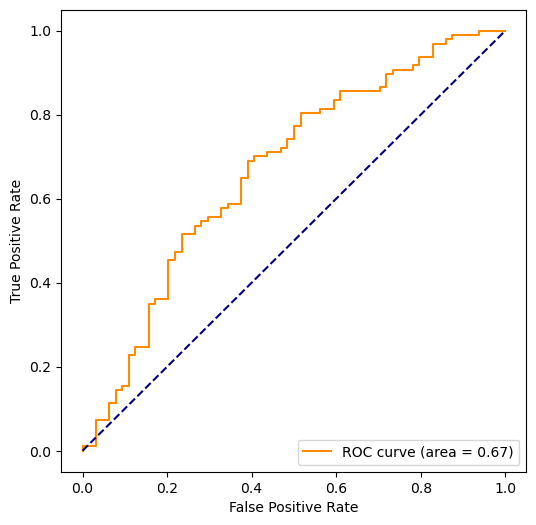

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8932, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (160, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6506691000358011
Test Loss: 0.5439157724380493
Epoch 2 of 10
Train Loss: 0.6171881508731116
Test Loss: 0.5288718819618226
Epoch 3 of 10
Train Loss: 0.6002441176479834
Test Loss: 0.5195412874221802
Epoch 4 of 10
Train Loss: 0.5854295183071575
Test Loss: 0.5053852438926697
Epoch 5 of 10
Train Loss: 0.5774005184352958
Test Loss: 0.49440852403640745
Epoch 6 of 10
Train Loss: 0.5700221768527409
Test Loss: 0.5012359380722046
exceeded delta
Epoch 7 of 10
Train Loss: 0.5696609802861092
Test Loss: 0.48062156438827514
Epoch 8 of 10
Train Loss: 0.5719523451224711
Test Loss: 0.492497980594635
exceeded delta
Epoch 9 of 10
Train Loss: 0.5702385103761269
Test Loss: 0.48125425577163694
Epo

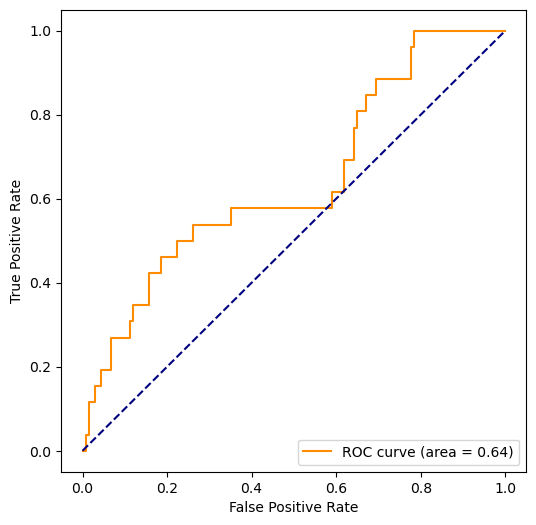

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8691, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (401, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.7213017353184711
Test Loss: 0.6945185958595942
Epoch 2 of 10
Train Loss: 0.6807362235274144
Test Loss: 0.6849227534267968
Epoch 3 of 10
Train Loss: 0.6620670586786697
Test Loss: 0.6818679134150099
Epoch 4 of 10
Train Loss: 0.6520648517812743
Test Loss: 0.6800248938011112
Epoch 5 of 10
Train Loss: 0.6411536974649602
Test Loss: 0.6675412470563095
Epoch 6 of 10
Train Loss: 0.6309604348501009
Test Loss: 0.6613129927333157
Epoch 7 of 10
Train Loss: 0.6265260176065532
Test Loss: 0.6557166392071884
Epoch 8 of 10
Train Loss: 0.6223969846336357
Test Loss: 0.6526096895745865
Epoch 9 of 10
Train Loss: 0.6202219909415148
Test Loss: 0.6461672985048366
Epoch 10 of 10
Train Loss: 0.618348

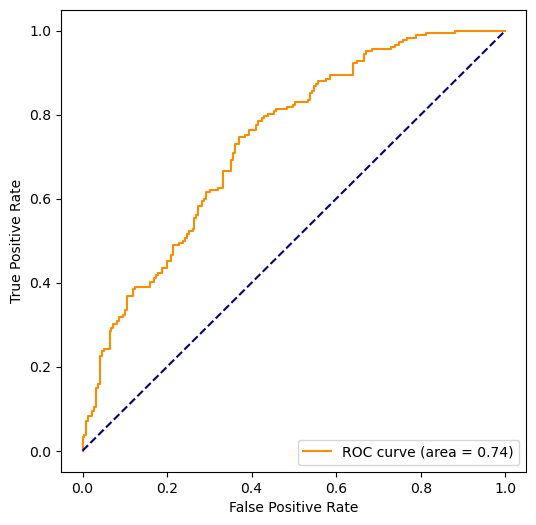

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8508, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (584, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6580413595073146
Test Loss: 0.6929461139522187
Epoch 2 of 10
Train Loss: 0.6184375298432357
Test Loss: 0.6914571686966778
Epoch 3 of 10
Train Loss: 0.5993946991899398
Test Loss: 0.6685106803293097
Epoch 4 of 10
Train Loss: 0.5881755951709684
Test Loss: 0.6777732992825443
exceeded delta
Epoch 5 of 10
Train Loss: 0.5840665228107921
Test Loss: 0.6568738189462113
Epoch 6 of 10
Train Loss: 0.5846831949876965
Test Loss: 0.6662628128104013
exceeded delta
Epoch 7 of 10
Train Loss: 0.578555154419304
Test Loss: 0.6581245464821385
Epoch 8 of 10
Train Loss: 0.5793267471105434
Test Loss: 0.6541026373432107
Epoch 9 of 10
Train Loss: 0.5785733618868535
Test Loss: 0.6515196398512958
Epoch 

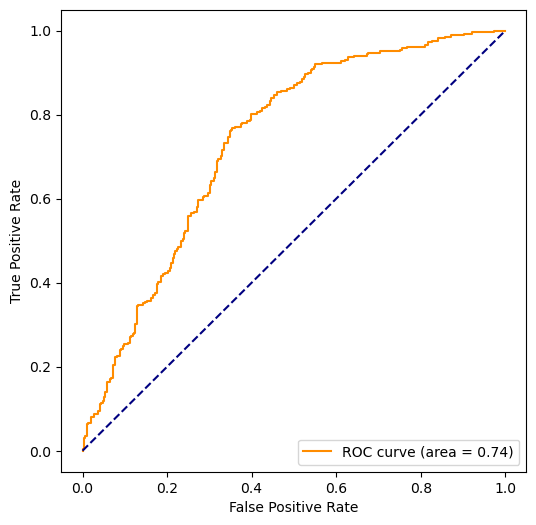

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8947, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (145, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6549455892763898
Test Loss: 0.5666433400121228
Epoch 2 of 10
Train Loss: 0.622317287180295
Test Loss: 0.5739179808517982
exceeded delta
Epoch 3 of 10
Train Loss: 0.6071222436831786
Test Loss: 0.555071679477034
Epoch 4 of 10
Train Loss: 0.6019447847253133
Test Loss: 0.562426652579472
exceeded delta
Epoch 5 of 10
Train Loss: 0.6003634068131034
Test Loss: 0.5569807249924232
Epoch 6 of 10
Train Loss: 0.599444658273663
Test Loss: 0.5870969048861799
exceeded delta
Epoch 7 of 10
Train Loss: 0.6018454132898701
Test Loss: 0.5612564218455347
exceeded delta
Epoch 8 of 10
Train Loss: 0.6020247516011717
Test Loss: 0.566146548040982
exceeded delta
Epoch 9 of 10
Train Loss: 0.604268655705

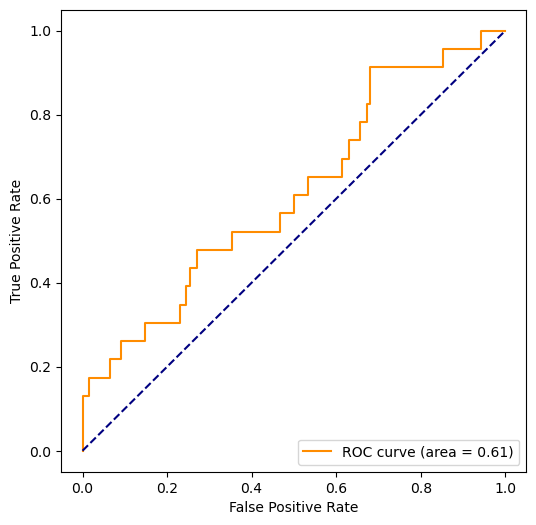

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8804, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (288, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6668593319152388
Test Loss: 0.7120623721016778
Epoch 2 of 10
Train Loss: 0.6264540073493566
Test Loss: 0.6962617768181695
Epoch 3 of 10
Train Loss: 0.601584095675422
Test Loss: 0.6902992592917548
Epoch 4 of 10
Train Loss: 0.5864350229217377
Test Loss: 0.6734631458918253
Epoch 5 of 10
Train Loss: 0.5738190111925471
Test Loss: 0.6747890181011624
Epoch 6 of 10
Train Loss: 0.5674487098354147
Test Loss: 0.677276247077518
Epoch 7 of 10
Train Loss: 0.5584332532419068
Test Loss: 0.67255566517512
Epoch 8 of 10
Train Loss: 0.5606356312718407
Test Loss: 0.6535423729154799
Epoch 9 of 10
Train Loss: 0.5599577982606588
Test Loss: 0.667706674999661
exceeded delta
Epoch 10 of 10
Train Loss

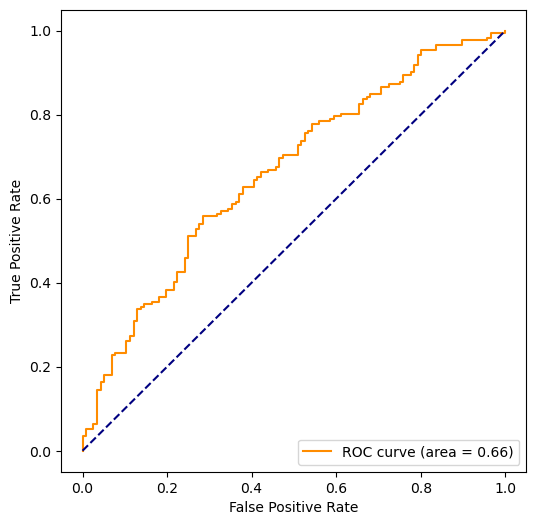

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (9016, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (76, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.68689544241092
Test Loss: 0.6932560519168252
Epoch 2 of 10
Train Loss: 0.6266117764450114
Test Loss: 0.7183540243851511
exceeded delta
Epoch 3 of 10
Train Loss: 0.6066798639170554
Test Loss: 0.7161354516681872
exceeded delta
Epoch 4 of 10
Train Loss: 0.5973347813657881
Test Loss: 0.7123085072166041
exceeded delta
Epoch 5 of 10
Train Loss: 0.5923723833901542
Test Loss: 0.7288463994076377
exceeded delta
Epoch 6 of 10
Train Loss: 0.5869063556776072
Test Loss: 0.7085195340608296
exceeded delta
Hit early stopping criteria
torch.Size([76, 1])
doing binary


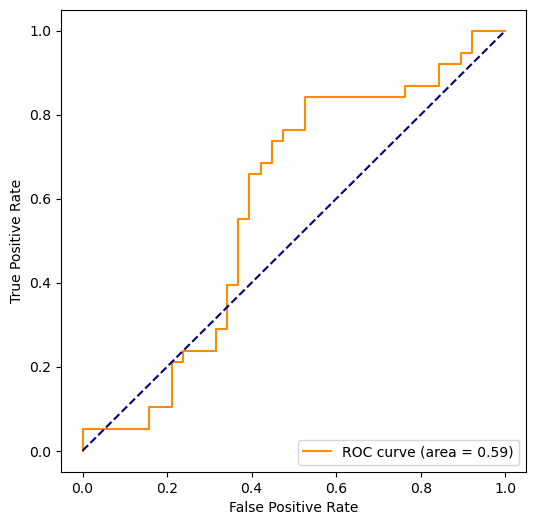

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8631, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (461, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6556245942834548
Test Loss: 0.43369436264038086
Epoch 2 of 10
Train Loss: 0.6272325114653597
Test Loss: 0.39242155070935825
Epoch 3 of 10
Train Loss: 0.6066996910635309
Test Loss: 0.3644781567786624
Epoch 4 of 10
Train Loss: 0.5986876484969582
Test Loss: 0.35481923366058415
Epoch 5 of 10
Train Loss: 0.5906170400956072
Test Loss: 0.35804457054220934
Epoch 6 of 10
Train Loss: 0.5853943314837934
Test Loss: 0.3819805288004513
exceeded delta
Epoch 7 of 10
Train Loss: 0.57852401927868
Test Loss: 0.33637074327779176
Epoch 8 of 10
Train Loss: 0.57807496430741
Test Loss: 0.34249872964788675
exceeded delta
Epoch 9 of 10
Train Loss: 0.5748335507167144
Test Loss: 0.3611459401062409
exc

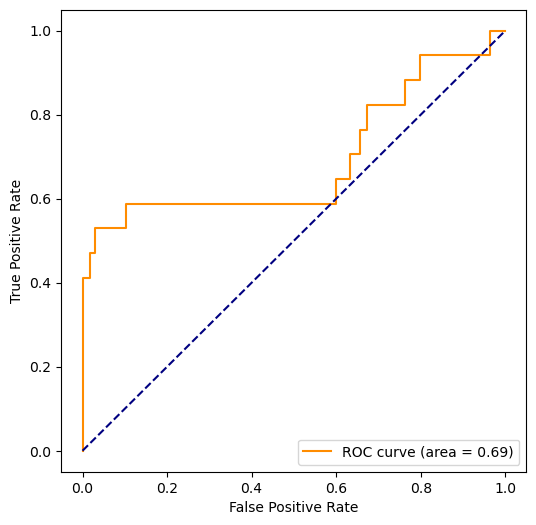

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (9045, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (47, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.652699873920565
Test Loss: 0.6236668850513215
Epoch 2 of 10
Train Loss: 0.6116645507222055
Test Loss: 0.5973566339371053
Epoch 3 of 10
Train Loss: 0.5923949737717527
Test Loss: 0.5595562711675116
Epoch 4 of 10
Train Loss: 0.5815877183752867
Test Loss: 0.5701245247049535
exceeded delta
Epoch 5 of 10
Train Loss: 0.5725008865955326
Test Loss: 0.5766332910415974
exceeded delta
Epoch 6 of 10
Train Loss: 0.5621220920282283
Test Loss: 0.5947908036252285
exceeded delta
Epoch 7 of 10
Train Loss: 0.5568719557071009
Test Loss: 0.7154412776865857
exceeded delta
Epoch 8 of 10
Train Loss: 0.5597854775575856
Test Loss: 0.6494873128038772
exceeded delta
Hit early stopping criteria
torch.Siz

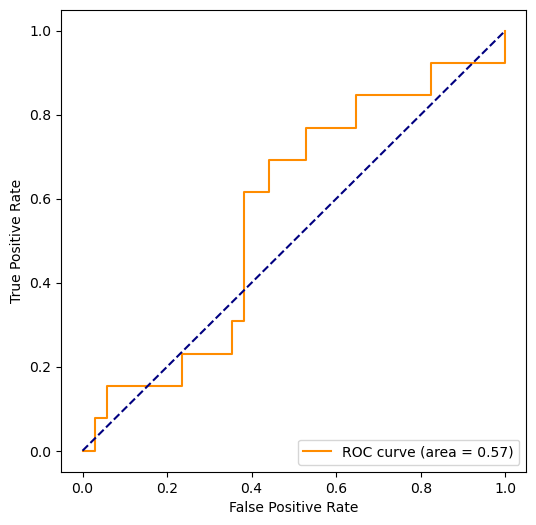

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8943, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (149, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6556981873834852
Test Loss: 0.8355654902106163
Epoch 2 of 10
Train Loss: 0.6252648435582201
Test Loss: 0.7950112259627988
Epoch 3 of 10
Train Loss: 0.6034126460892129
Test Loss: 0.7222463236559158
Epoch 4 of 10
Train Loss: 0.5914432436484399
Test Loss: 0.6843854788965826
Epoch 5 of 10
Train Loss: 0.5789391913163933
Test Loss: 0.6627579823436353
Epoch 6 of 10
Train Loss: 0.575323407287154
Test Loss: 0.6380985247208768
Epoch 7 of 10
Train Loss: 0.5693787827822875
Test Loss: 0.627364907488727
Epoch 8 of 10
Train Loss: 0.5698475816912877
Test Loss: 0.6157886133898025
Epoch 9 of 10
Train Loss: 0.569342618232257
Test Loss: 0.6609213656227061
exceeded delta
Epoch 10 of 10
Train Lo

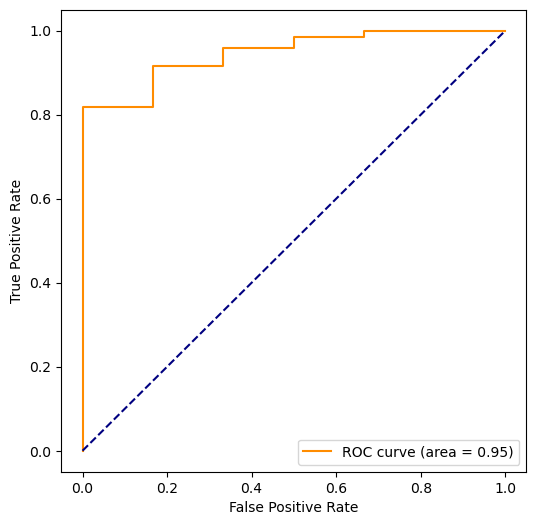

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8737, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (355, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6800995881625412
Test Loss: 0.6811362414292886
Epoch 2 of 10
Train Loss: 0.6579712340197847
Test Loss: 0.6725429803552762
Epoch 3 of 10
Train Loss: 0.6379657543209006
Test Loss: 0.6617028249821193
Epoch 4 of 10
Train Loss: 0.6161158628181037
Test Loss: 0.6491766755010041
Epoch 5 of 10
Train Loss: 0.5996753122408958
Test Loss: 0.6393500529544455
Epoch 6 of 10
Train Loss: 0.5861041328925296
Test Loss: 0.6309879571619168
Epoch 7 of 10
Train Loss: 0.5744052761218034
Test Loss: 0.630138945243728
Epoch 8 of 10
Train Loss: 0.573741740160926
Test Loss: 0.6390982184611576
exceeded delta
Epoch 9 of 10
Train Loss: 0.5722514007680133
Test Loss: 0.626596552889112
Epoch 10 of 10
Train Lo

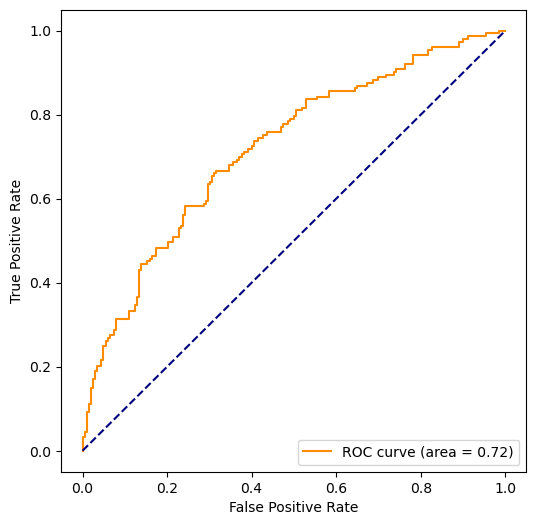

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8585, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (507, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6521803037746743
Test Loss: 0.6348862732655903
Epoch 2 of 10
Train Loss: 0.6169837577299941
Test Loss: 0.6380921914967794
Epoch 3 of 10
Train Loss: 0.6028028417619495
Test Loss: 0.6433086809086846
exceeded delta
Epoch 4 of 10
Train Loss: 0.5918834657952337
Test Loss: 0.645679586737819
exceeded delta
Epoch 5 of 10
Train Loss: 0.5854550454390208
Test Loss: 0.6497269504404162
exceeded delta
Epoch 6 of 10
Train Loss: 0.5850138409858398
Test Loss: 0.6509069634612495
exceeded delta
Epoch 7 of 10
Train Loss: 0.5864284348751684
Test Loss: 0.6436614614031488
exceeded delta
Hit early stopping criteria
torch.Size([507, 1])
doing binary


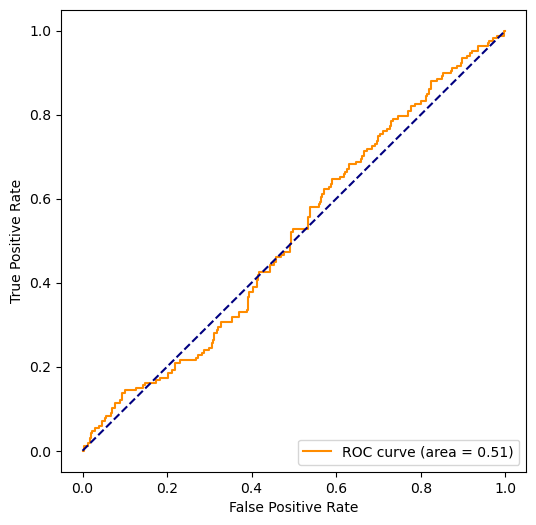

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8595, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (497, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6446235230663893
Test Loss: 0.7532667470889792
Epoch 2 of 10
Train Loss: 0.6137396909526228
Test Loss: 0.7420969527492101
Epoch 3 of 10
Train Loss: 0.6032473417130093
Test Loss: 0.7393492117254307
Epoch 4 of 10
Train Loss: 0.5968896152392038
Test Loss: 0.7407808131135446
Epoch 5 of 10
Train Loss: 0.5931000408285784
Test Loss: 0.7292286279935473
Epoch 6 of 10
Train Loss: 0.5905504576198718
Test Loss: 0.7493036220251195
exceeded delta
Epoch 7 of 10
Train Loss: 0.5916834080614553
Test Loss: 0.736589688890177
exceeded delta
Epoch 8 of 10
Train Loss: 0.592963954665898
Test Loss: 0.7262696433115293
Epoch 9 of 10
Train Loss: 0.595357501666306
Test Loss: 0.7357934456715881
exceeded

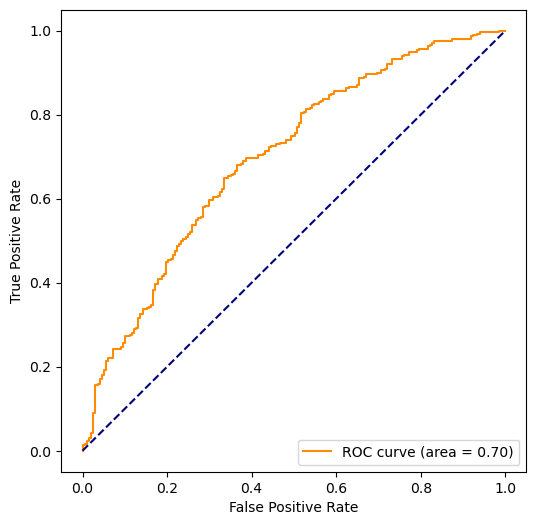

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8934, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (158, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6779093591857869
Test Loss: 0.5606759952593453
Epoch 2 of 10
Train Loss: 0.6089206927837288
Test Loss: 0.5688615871381156
exceeded delta
Epoch 3 of 10
Train Loss: 0.5929920942905581
Test Loss: 0.579898810084862
exceeded delta
Epoch 4 of 10
Train Loss: 0.5868700628235806
Test Loss: 0.5546574049358126
Epoch 5 of 10
Train Loss: 0.5834011921606156
Test Loss: 0.5614953101435795
exceeded delta
Epoch 6 of 10
Train Loss: 0.5830269844067132
Test Loss: 0.5529719726948799
Epoch 7 of 10
Train Loss: 0.5795421169085446
Test Loss: 0.5523389623134951
Epoch 8 of 10
Train Loss: 0.5762050533444123
Test Loss: 0.5574344562578805
Epoch 9 of 10
Train Loss: 0.5780621213295969
Test Loss: 0.53635407

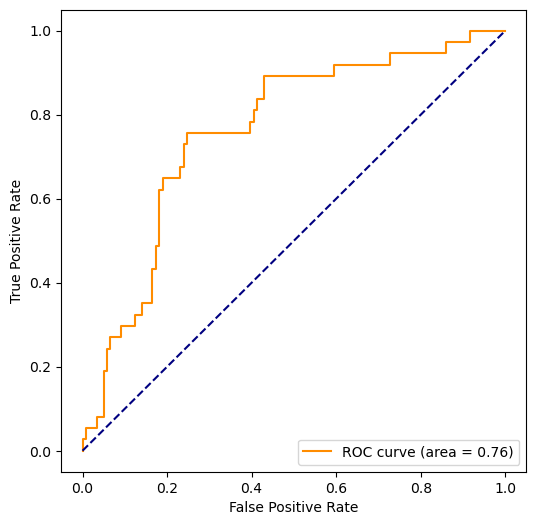

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8812, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (280, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.6597912719560329
Test Loss: 0.5859275409153529
Epoch 2 of 10
Train Loss: 0.6371122964988012
Test Loss: 0.5772005660193307
Epoch 3 of 10
Train Loss: 0.6215101468038191
Test Loss: 0.5762036493846349
Epoch 4 of 10
Train Loss: 0.6119563790597106
Test Loss: 0.5733487742287772
Epoch 5 of 10
Train Loss: 0.6056597625673548
Test Loss: 0.5793526036398752
exceeded delta
Epoch 6 of 10
Train Loss: 0.6005545978485537
Test Loss: 0.5697401591709682
Epoch 7 of 10
Train Loss: 0.5910853010602718
Test Loss: 0.5664741107395717
Epoch 8 of 10
Train Loss: 0.5870500199642172
Test Loss: 0.5718599660055977
Epoch 9 of 10
Train Loss: 0.581620305763068
Test Loss: 0.5711331844329834
Epoch 10 of 10
Train 

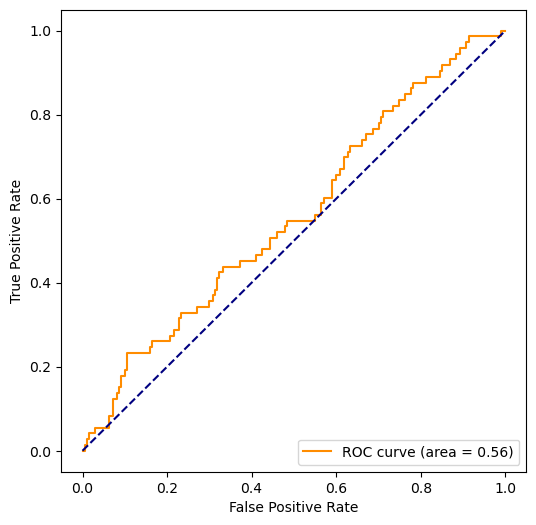

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (8621, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (471, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.671164877355797
Test Loss: 0.5517596145597486
Epoch 2 of 10
Train Loss: 0.633149914641403
Test Loss: 0.495667151837845
Epoch 3 of 10
Train Loss: 0.6139770076828259
Test Loss: 0.4794994544577953
Epoch 4 of 10
Train Loss: 0.6000210985812714
Test Loss: 0.43419239424849265
Epoch 5 of 10
Train Loss: 0.5908991312872796
Test Loss: 0.41203142477954774
Epoch 6 of 10
Train Loss: 0.5887266888500656
Test Loss: 0.48693149509956374
exceeded delta
Epoch 7 of 10
Train Loss: 0.5799357004168968
Test Loss: 0.49169980391322177
exceeded delta
Epoch 8 of 10
Train Loss: 0.5757978359904288
Test Loss: 0.5073070748849533
exceeded delta
Epoch 9 of 10
Train Loss: 0.574079378148185
Test Loss: 0.5497658

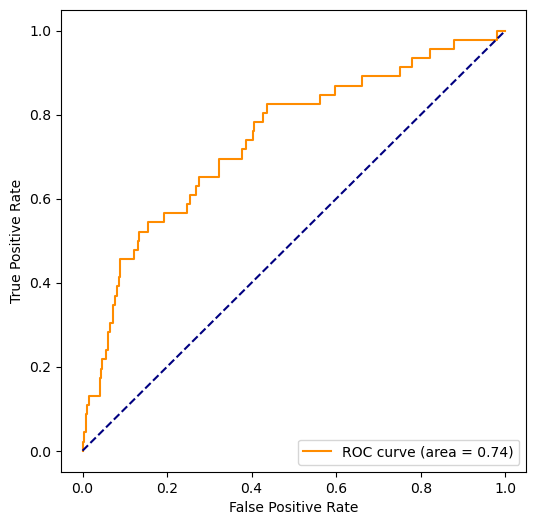

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (9011, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (81, 1000)
Found 1000 overlapping genes
Epoch 1 of 10
Train Loss: 0.7443933403329254
Test Loss: 0.7281545591943058
Epoch 2 of 10
Train Loss: 0.6269790510559251
Test Loss: 0.6309320308544017
Epoch 3 of 10
Train Loss: 0.5924864699025356
Test Loss: 0.6480895148383247
exceeded delta
Epoch 4 of 10
Train Loss: 0.5770465267470536
Test Loss: 0.6271308498618043
Epoch 5 of 10
Train Loss: 0.57216018318614
Test Loss: 0.6053806940714518
Epoch 6 of 10
Train Loss: 0.5631582499106046
Test Loss: 0.6370265984240874
exceeded delta
Epoch 7 of 10
Train Loss: 0.5582670665398487
Test Loss: 0.6770351786672333
exceeded delta
Epoch 8 of 10
Train Loss: 0.559273226493181
Test Loss: 0.6199459735258126
exceeded delta
Epoch 9 of 10
Train Loss: 0.5595581430188163
Test Loss

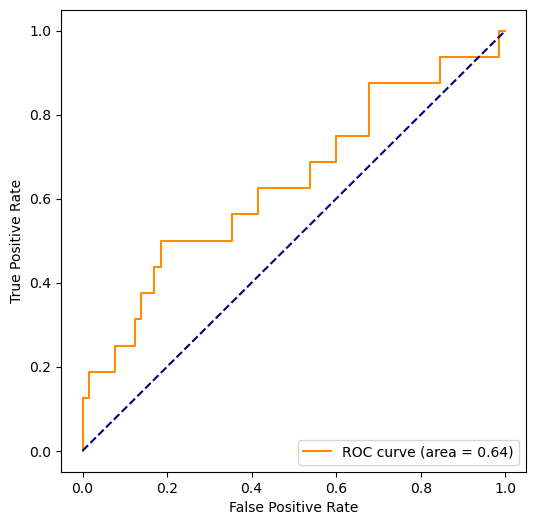

In [45]:
leave_one_out_auc = {}
for cancer in cancer_types:
    test_inds = list(tumor[tumor['tumor'] == cancer].index)
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         absolute_ploidy_y,
                                                                         verbose=True,
                                                                         early_stopping=True,
                                                                            test_inds=test_inds)
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y
    model.to('cpu')

    pred = model(x_test, additional_test).detach()
    auc = util.get_auc(pred, y_test)
    leave_one_out_auc[cancer] = auc

In [57]:
leave_one_out_auc = pd.DataFrame.from_dict(leave_one_out_auc, orient='index')
leave_one_out_auc.columns = ['AUC']
leave_one_out_auc['AUC'] = leave_one_out_auc['AUC'].astype(float)
leave_one_out_auc.index.names = ['tumor']

tvc = pd.DataFrame(tumor.value_counts(), columns=['samples']).reset_index()
tvc = tvc.set_index('tumor')


df = tumor.join(absolute_ploidy)
tmp = df.groupby('tumor').mean()

leave_one_out_auc = leave_one_out_auc.join(tmp, how='inner')
leave_one_out_auc = leave_one_out_auc.join(tvc, how='inner')

TypeError: 'numpy.ndarray' object is not callable

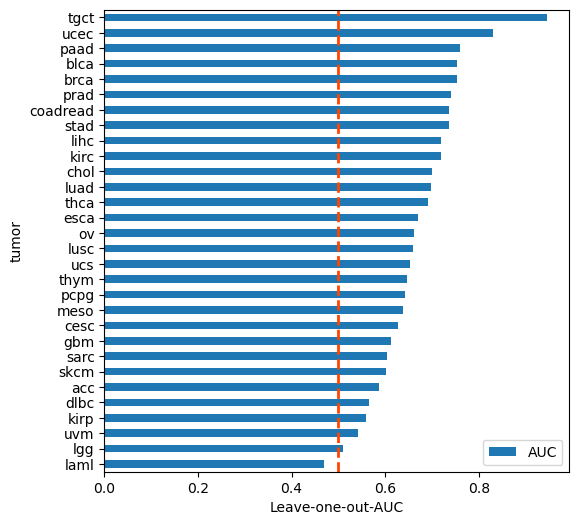

In [134]:
leave_one_out_auc.sort_values('AUC').plot.barh(y='AUC')
plt.xlabel('Leave-one-out-AUC')
plt.axvline(0.5, color='orangered', linestyle='--', linewidth=2)
plt.show()

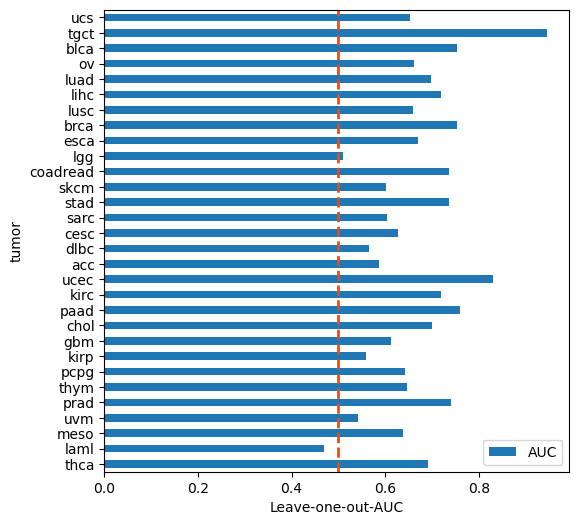

In [132]:
leave_one_out_auc.sort_values('ploidy').plot.barh(y='AUC')
plt.xlabel('Leave-one-out-AUC')
plt.axvline(0.5, color='orangered', linestyle='--', linewidth=2)
plt.show()

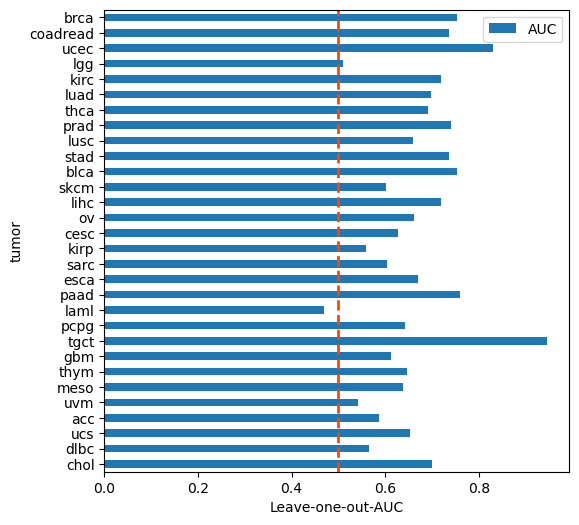

In [133]:
leave_one_out_auc.sort_values('samples').plot.barh(y='AUC')
plt.xlabel('Leave-one-out-AUC')
plt.axvline(0.5, color='orangered', linestyle='--', linewidth=2)
plt.show()

In [44]:
feature_importances, additional_importances = model.integrated_gradients(test_dataset)

In [51]:
feature_importances.sum().nlargest(20)

POC5        120.689145
TOE1        113.945805
WDR76       103.948810
CDK18       102.916479
MR1         102.339670
TAGLN       100.209361
RPL4         91.813087
FBXL5        89.261956
C16orf71     88.853988
REPIN1       85.818983
TSPAN3       82.250876
PWWP2A       75.207442
BCL7A        72.407136
PTMA         62.602751
FBXO36       61.157005
PTPRCAP      59.644888
TSNAXIP1     57.923517
HARS         56.175618
HDAC3        55.739594
FBXO42       51.759455
dtype: float64

In [52]:
layerwise_imps = model.layerwise_importance(test_dataset)

In [53]:
for l in layerwise_imps:
    print(l.nlargest(5))

Gluconeogenesis                                                  20.799564
Major pathway of rRNA processing in the nucleolus and cytosol     8.783642
rRNA modification in the nucleus and cytosol                      2.481303
Antigen processing: Ubiquitination & Proteasome degradation       0.164913
Response of EIF2AK4 (GCN2) to amino acid deficiency               0.087017
dtype: float32
Heme signaling                                        37.348900
Anchoring of the basal body to the plasma membrane    30.850626
Intraflagellar transport                              27.835035
Protein methylation                                   22.504049
Glucose metabolism                                    20.789555
dtype: float32
Iron uptake and transport                  89.062851
Cilium Assembly                            60.447666
Post-translational protein modification    42.937241
Membrane Trafficking                       32.335323
Cellular responses to stress               31.438164
dtype: flo

<AxesSubplot: xlabel='POC5', ylabel='Density'>

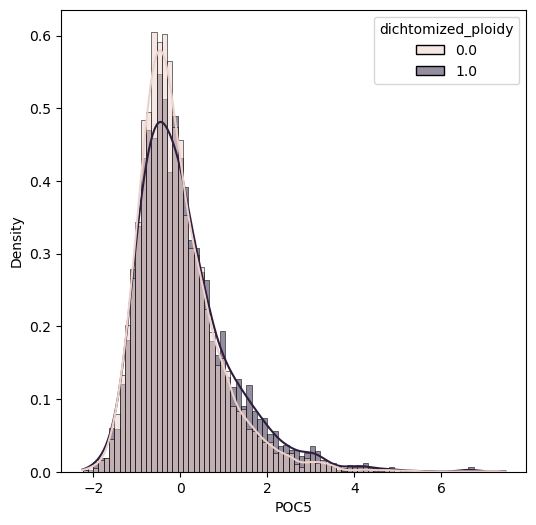

In [106]:
sns.histplot(data=rna.join(absolute_ploidy_y), x='POC5', hue='dichtomized_ploidy',bins=80,
             stat='density', kde=True, common_norm=False)

In [ ]:
gene_order = high_ploidy_importances.median().sort_values(ascending=True).index
gene_order

In [ ]:
high_ploidy_importances = gene_importances[gene_importances.join(absolute_ploidy_y)['dichtomized_ploidy'] == 1]

In [ ]:
plt.rcParams["figure.figsize"] = (6,8)
high_ploidy_importances[list(gene_order[-20:])].plot(kind='box', vert=False, showfliers=False)
plt.savefig('../figures/genes_ploidy.pdf')
plt.show()

In [ ]:
pathway_importances = model.layerwise_importance(test_dataset)

In [ ]:
for l in pathway_importances:
    print(l.nlargest(5))

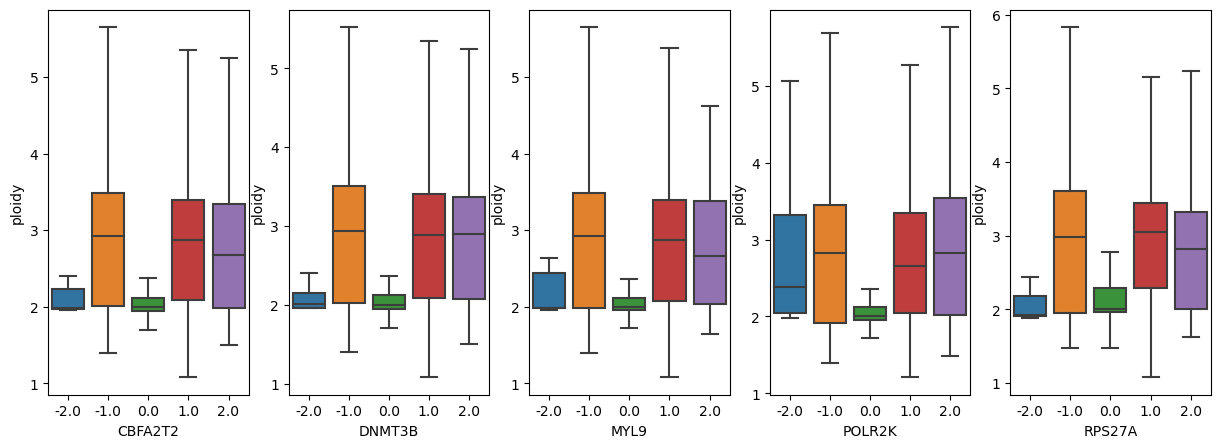

In [69]:
some_genes = ['CBFA2T2', 'DNMT3B', 'MYL9', 'POLR2K', 'RPS27A']
fig, axs = plt.subplots(1, 5, figsize=((15, 5)))
for i, gene in enumerate(some_genes):
    gene = gene.split('_')[0]
    sns.boxplot(data=cna.join(absolute_ploidy), x=gene, y='ploidy', ax=axs[i], showfliers=False)
plt.savefig('../figures/cna_vs_ploiy_top_genes.pdf')
plt.show()

In [81]:
pred = torch.sigmoid(model(x_test, additional_test))

In [82]:
pred_ = pd.DataFrame(pred.detach().numpy(), index=test_dataset.input_df.index, columns=['prediction'])

In [83]:
pred_.join(tumor)

,prediction,tumor
TCGA-KQ-A41Q-01,0.591419,blca
TCGA-WB-A80N-01,0.187834,pcpg
TCGA-FA-A4XK-01,0.377260,dlbc
TCGA-EJ-5526-01,0.227813,prad
TCGA-DK-A6B6-01,0.457677,blca
...,...,...
TCGA-FE-A3PB-01,0.174474,thca
TCGA-26-5133-01,0.470625,gbm
TCGA-KV-A6GE-01,0.421287,kirp
TCGA-D9-A1JW-06,0.453414,skcm


In [95]:
df['tumor'].values[0].upper()

'BLCA'

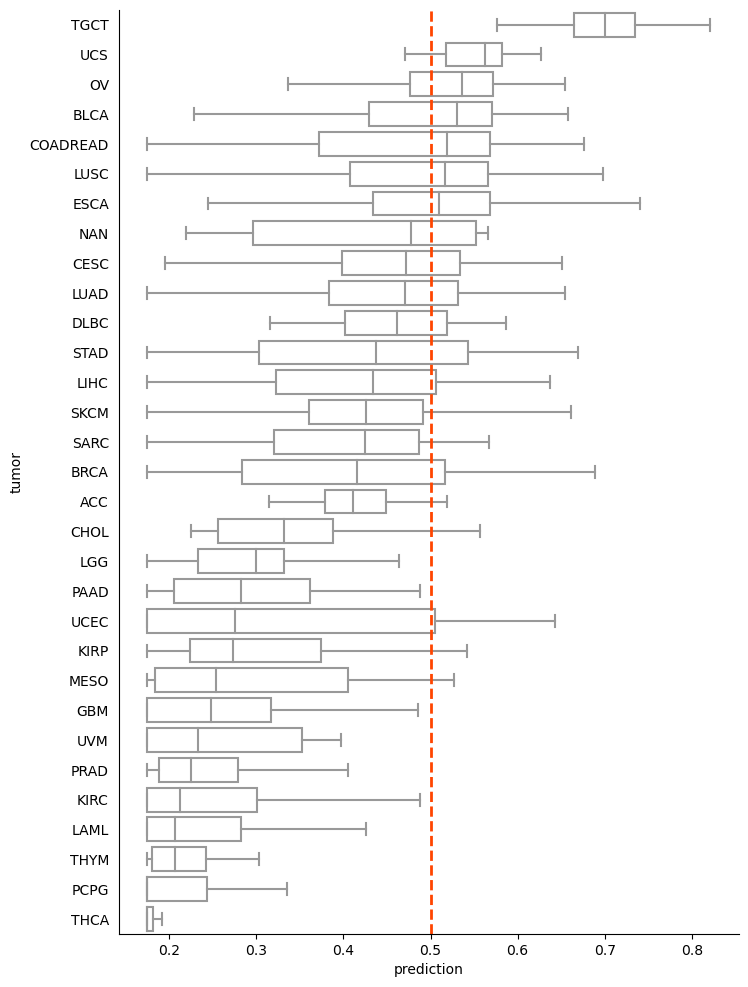

In [100]:
df = pred_.join(tumor)
df['tumor'] = [str(x).upper() for x in df['tumor'].values]
tumor_order = list(df.groupby('tumor').median().sort_values('prediction', ascending=False).index)
plt.rcParams["figure.figsize"] = (8,12)
sns.boxplot(df, x='prediction', y='tumor', order=tumor_order, color='w', showfliers=False)
plt.axvline(0.5, color='orangered', linestyle='--', linewidth=2)
plt.tick_params(axis='y', which='both',  left=False, top=False, labelleft=True)
sns.despine()
plt.savefig('../figures/prediction_by_tumortype.pdf')

In [103]:
missclass_df.groupby('tumor').mean()

,prediction,dichtomized_ploidy,misclass
tumor,,,
acc,0.411977,0.428571,0.380952
blca,0.480079,0.638655,0.277311
brca,0.400389,0.509434,0.342767
cesc,0.458409,0.364706,0.376471
chol,0.346802,0.200000,0.100000
coadread,0.467952,0.491803,0.245902
dlbc,0.459572,0.235294,0.352941
esca,0.489336,0.596491,0.280702
gbm,0.275600,0.114286,0.142857


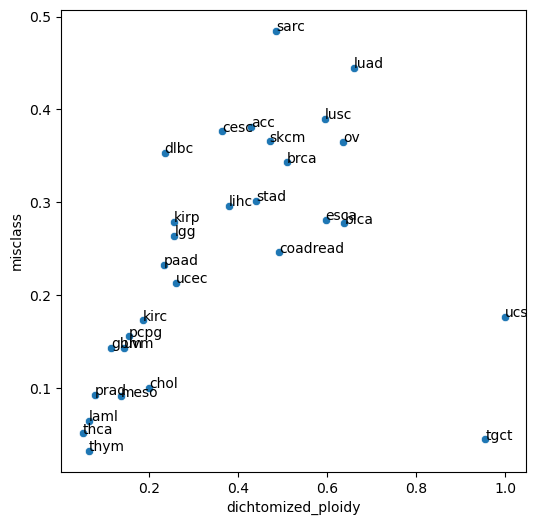

In [102]:
plt.rcParams["figure.figsize"] = (6,6)
missclass_df = pred_.join(tumor).join(test_dataset.target)
missclass_df['misclass'] = missclass_df.apply(lambda x: 1-int(round(x['prediction'])==x['dichtomized_ploidy']), axis=1)
sns.scatterplot(missclass_df.groupby('tumor').mean(), x='dichtomized_ploidy', y='misclass')
for tum in missclass_df.groupby('tumor').mean().index:
    plt.annotate(missclass_df.groupby('tumor').mean().loc[tum].name,
                (missclass_df.groupby('tumor').mean().loc[tum]['dichtomized_ploidy'],
                 missclass_df.groupby('tumor').mean().loc[tum]['misclass']))
plt.savefig('../figures/ploidy_vs_misclass_by_tumortype.pdf')

## Multiple runs

In [ ]:
def fold_run(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(x,
                                                                             y,
                                                                             verbose=False,
                                                                             early_stopping=True)

        x_train = train_dataset.input_df.astype(float).values
        additional_train = train_dataset.additional_data.astype(float).values
        y_train = train_dataset.target.astype(float).values.reshape(-1)
        x_test = test_dataset.input_df.astype(float).values
        additional_test = test_dataset.additional_data.astype(float).values
        y_test = test_dataset.target.astype(float).values.reshape(-1)

        pred = model(torch.tensor(x_test, dtype=torch.float),
                                  torch.tensor(additional_test, dtype=torch.float)
                    )
        y_pred_proba = pred.detach().numpy().squeeze()
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        test_auc = metrics.roc_auc_score(y_test, pred.detach().numpy().squeeze())

        aucs.append(test_auc)

        gene_importances, additional_importances = model.deepLIFT(test_dataset)
        most_imp_genes.append(gene_importances.sum())
    return aucs, most_imp_genes

In [ ]:
def fold_run_rf(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        train_dataset, test_dataset = pnet_loader.generate_train_test(x, y, None, None, 0.3, None)
        clf = RandomForestClassifier()
        clf.fit(train_dataset.input_df.values, train_dataset.target.values.reshape(-1))
        
        x_train = train_dataset.input_df.astype(float).values
        additional_train = train_dataset.additional_data.astype(float).values
        y_train = train_dataset.target.astype(float).values.reshape(-1)
        x_test = test_dataset.input_df.astype(float).values
        additional_test = test_dataset.additional_data.astype(float).values
        y_test = test_dataset.target.astype(float).values.reshape(-1)

        y_pred_proba = clf.predict_proba(x_test)
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba[:,1])
        test_auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])

        aucs.append(test_auc)

        gene_importances = clf.feature_importances_
        most_imp_genes.append(pd.DataFrame(clf.feature_importances_, index=test_dataset.input_df.columns))
    return aucs, most_imp_genes

In [ ]:
ploidy_absolut_auc, ploidy_absolut_genes = fold_run(genetic_data, absolute_ploidy_y, 10)
ploidy_absolut_auc_rf, ploidy_absolut_genes_rf = fold_run_rf(genetic_data, absolute_ploidy_y, 10)

In [ ]:
data_pnet = [ploidy_absolut_auc]
data_rf = [ploidy_absolut_auc_rf]

ticks = ['ploidy \n by absolut']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
    
bpl = plt.boxplot(data_pnet, positions=np.array(range(len(data_pnet)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_rf, positions=np.array(range(len(data_pnet)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

plt.plot([], c='#D7191C', label='pnet')
plt.plot([], c='#2C7BB6', label='rf')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.savefig('absolute_ploidy_auc_pnet_vs_rf.pdf')

In [ ]:
ploidy_absolut_genes

In [ ]:
ploidy_absolut_genes_rf

In [ ]:
gene_order = pd.DataFrame(ploidy_absolut_genes).mean().sort_values(ascending=False).index
df_sum = pd.DataFrame(ploidy_absolut_genes)

In [ ]:
gene_order_rf = pd.DataFrame([x[0] for x in ploidy_absolut_genes_rf]).mean().sort_values(ascending=False).index
df_sum_rf = pd.DataFrame([x[0] for x in ploidy_absolut_genes_rf])

In [ ]:
plt.rcParams["figure.figsize"] = (6,8)
df_sum[list(gene_order[:20]) + list(gene_order[-20:])].plot(kind='box', vert=False)
plt.savefig('Ploidy_important_genes.pdf')
plt.show()

In [ ]:
def check_annotate(x, y):
    if y > 1e-3/(x)**1.9 + 1e-3:
        return True
    else:
        return False

In [ ]:
import scipy.stats as ss

In [ ]:
comb_df['pnet_rank'] = ss.rankdata(comb_df['pnet_imp'])
comb_df['rf_rank'] = ss.rankdata(comb_df['rf_imp'])

In [ ]:
comb_df = pd.DataFrame([df_sum.mean(), df_sum_rf.mean()]).T
comb_df.columns = ['pnet_imp', 'rf_imp']
comb_df['pnet_rank'] = len(comb_df['pnet_imp']) - ss.rankdata(abs(comb_df['pnet_imp']))
comb_df['rf_rank'] = len(comb_df['rf_imp']) - ss.rankdata(abs(comb_df['rf_imp']))
comb_df['annotate'] = comb_df.apply(lambda x: x['pnet_rank'] + x['rf_rank'] < 100, axis=1)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(comb_df['pnet_imp'], comb_df['rf_imp'], s=10)

for i in range(len(comb_df)):
    if comb_df.iloc[i]['annotate']:
        ax.annotate(comb_df.iloc[i].name, (comb_df.iloc[i]['pnet_imp'], comb_df.iloc[i]['rf_imp']))

plt.ylabel('rf importance')
plt.xlabel('pnet importance')
plt.title('Ploidy classification gene importance')
plt.savefig('important_genes_ploidy_scatter.pdf')
plt.show()

In [ ]:
import gseapy as gp

In [ ]:
def prerank_gsea(gene_importances, gene_list):
    gene_sets='../data/reactome/ReactomePathways.gmt'
    gene_importance_scores = pd.DataFrame(index=gene_list)
    gene_importance_scores['1'] = gene_importances.values.reshape((2,-1)).sum(axis=0)
        
    pre_res = gp.prerank(rnk=gene_importance_scores,
                         gene_sets = gene_sets,
                         threads=8,
                         min_size=5,
                         max_size=1000,
                         permutation_num=1000,
                         outdir='../prerank_gsea',
                         seed=6,
                         verbose=True
                        )
    return pre_res

In [ ]:
pre_res_rf = prerank_gsea(comb_df['rf_imp'], list(comb_df.iloc[:int(comb_df.shape[0]/2)].index))

In [ ]:
top_hits_rf = list(pre_res_rf.res2d.sort_values('NOM p-val').head(15)['Term'])

In [ ]:
top_hits_rf

In [ ]:
pre_res_pnet = prerank_gsea(comb_df['pnet_imp'], list(comb_df.iloc[:int(comb_df.shape[0]/2)].index))

In [ ]:
top_hits_pnet = list(pre_res_pnet.res2d.sort_values('NOM p-val').head(15)['Term'])

In [ ]:
top_hits_pnet